<a href="https://colab.research.google.com/github/BhavyaSamhithaMallineni/541_CV_Project/blob/main/ASL_Project_Trojan7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gtts


# **Application of Computer Vision for American Sign Language Detection**




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset
from torchvision.datasets import ImageFolder
import numpy as np
import os
from PIL import Image
from google.colab import drive
from gtts import gTTS
import IPython.display as ipd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
drive.mount('/content/drive')

 **Data Importing and Preprocessing Configuration for Training**

Our data is being imported from Kaggle and loaded into Colab Notebook for the purpose of training and testing the model. There is a test set and a training set in the provided dataset. Since the test set lacks class separation but the training set does, we are employing a testing set with class separated data for testing purposes. Our training dataset is being divided into two categories: training data (80%) and validation data (20%).

In [ ]:
! export KAGGLE_USERNAME="samhithamallineni" && export KAGGLE_KEY="ebd416302f571eab98fde79290248f1c" && kaggle datasets download --unzip grassknoted/asl-alphabet
! ls

100% 1.02G/1.03G [00:30<00:00, 43.1MB/s]
100% 1.03G/1.03G [00:30<00:00, 36.2MB/s]
asl_alphabet_test  asl_alphabet_train  sample_data


In [ ]:
train_data_path="/content/asl_alphabet_train/asl_alphabet_train"
test_data_path="/content/drive/MyDrive/asl_alphabet_test"

Transforms module

In [ ]:
img_size = (64, 64)
batch_size = 32
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Splitting the dataset into 80% Training data and 20% Validation data

In [ ]:
dataset = ImageFolder(root=train_data_path, transform=data_transforms)

In [ ]:
dataset_size = len(dataset)
split = int(0.8 * dataset_size)
indices = list(range(dataset_size))
np.random.shuffle(indices)
train_indices, val_indices = indices[:split], indices[split:]
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [ ]:
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=4)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=4)


In [ ]:
test_data_path="/content/drive/MyDrive/asl_alphabet_test"
test_dataset = ImageFolder(root=test_data_path, transform=data_transforms)
test_loader=DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=4)

**ResNET Architecture**

We define our fundamental Resnet architecture. With the help of batch normalization and convolutional layers, it builds a sequence of residual blocks (blocks), which together form a deep neural network.  In order to facilitate the gradient flow during training, the ResNet structure consists  (_make_layer) with skip connections, which culminate in a fully linked layer for classification. The _make_layer function modifies channels and dimensions as necessary while stacking leftover blocks to create distinct network stages.

In [ ]:
class block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1, stride=stride),
                                                nn.BatchNorm2d(out_channels * 4))

        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels * 4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)


Three RestNet Architectures

In [ ]:
def ResNet50(img_channels=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channels, num_classes)
def ResNet101(img_channels=3, num_classes=1000):
    return ResNet(block, [3, 4, 23, 3], img_channels, num_classes)
def ResNet152(img_channels=3, num_classes=1000):
    return ResNet(block, [3, 8, 36, 3], img_channels, num_classes)

 **Training Our Model**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
num_classes = 29

In [ ]:
def train_model(model, num_epochs, train_loader, val_loader, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_loss = running_loss / len(train_loader)
        accuracy_train = correct_train / total_train * 100


        model.eval()
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            val_running_loss = 0.0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                val_loss = criterion(outputs, labels)
                val_running_loss += val_loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        average_val_loss = val_running_loss / len(val_loader)
        accuracy_val = correct_val / total_val * 100


        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Training Loss: {average_loss:.4f}, "
              f"Training Accuracy: {accuracy_train:.2f}%, "
              f"Validation Loss: {average_val_loss:.4f}, "
              f"Validation Accuracy: {accuracy_val:.2f}%")


        train_accuracy = correct_train / total_train * 100
        val_accuracy = correct_val / total_val * 100
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_losses.append(average_loss)
        val_losses.append(average_val_loss)

    return train_accuracies, val_accuracies, train_losses, val_losses



In [ ]:
models = {
    'ResNet50': ResNet50(img_channels=3, num_classes=num_classes),
    'ResNet101': ResNet101(img_channels=3, num_classes=num_classes),
    'ResNet152': ResNet152(img_channels=3, num_classes=num_classes)
}

In [ ]:
training_results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.to(device)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=4)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=4)
    num_epochs=5
    train_acc, val_acc, train_los, val_los = train_model(model, num_epochs, train_loader, val_loader, device)
    training_results[model_name] = {'train_acc': train_acc, 'val_acc': val_acc}

Training ResNet50...
Epoch [1/5], Training Loss: 0.7349, Training Accuracy: 76.91%, Validation Loss: 0.0559, Validation Accuracy: 98.13%
Epoch [2/5], Training Loss: 0.0881, Training Accuracy: 97.20%, Validation Loss: 0.0864, Validation Accuracy: 96.91%
Epoch [3/5], Training Loss: 0.0484, Training Accuracy: 98.53%, Validation Loss: 0.0087, Validation Accuracy: 99.77%
Epoch [4/5], Training Loss: 0.0368, Training Accuracy: 98.88%, Validation Loss: 0.0325, Validation Accuracy: 99.03%
Epoch [5/5], Training Loss: 0.0260, Training Accuracy: 99.18%, Validation Loss: 0.0090, Validation Accuracy: 99.65%
Training ResNet101...
Epoch [1/5], Training Loss: 0.8049, Training Accuracy: 74.45%, Validation Loss: 0.1725, Validation Accuracy: 94.41%
Epoch [2/5], Training Loss: 0.0967, Training Accuracy: 96.75%, Validation Loss: 0.0735, Validation Accuracy: 97.69%
Epoch [3/5], Training Loss: 0.0565, Training Accuracy: 98.14%, Validation Loss: 0.0232, Validation Accuracy: 99.18%
Epoch [4/5], Training Loss: 0

**Plotting and Model Evaluation**

On the validation set, we are analyzing our models . We will be using ResNet50 going forward since, as the figures demonstrate, its validation accuracy is high. We them compute the metrix on the validation set and test set

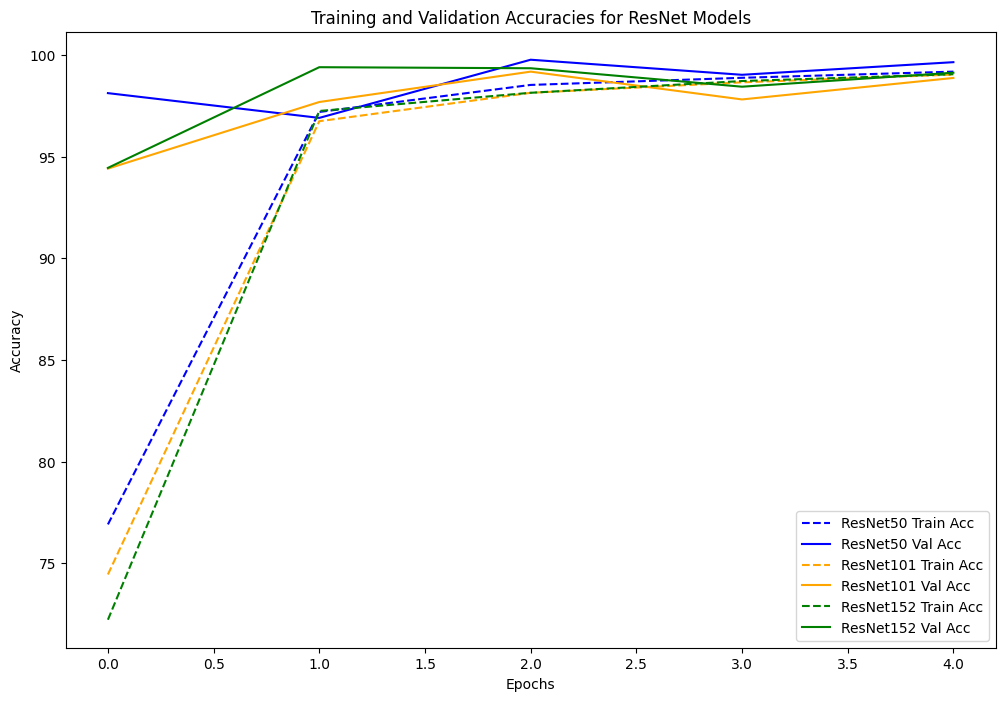

In [ ]:
plt.figure(figsize=(12, 8))

colors = ['blue', 'orange', 'green']

for i, (model_name, result) in enumerate(training_results.items()):
    plt.plot(range(num_epochs), result['train_acc'], label=f'{model_name} Train Acc', color=colors[i], linestyle='--')
    plt.plot(range(num_epochs), result['val_acc'], label=f'{model_name} Val Acc', color=colors[i])

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies for ResNet Models')
plt.legend()
plt.show()


Model Precision: 0.9890734198071682
Model Recall: 0.988735632183908
Model F1 Score: 0.9887199824645136
Model Confusion Matrix:


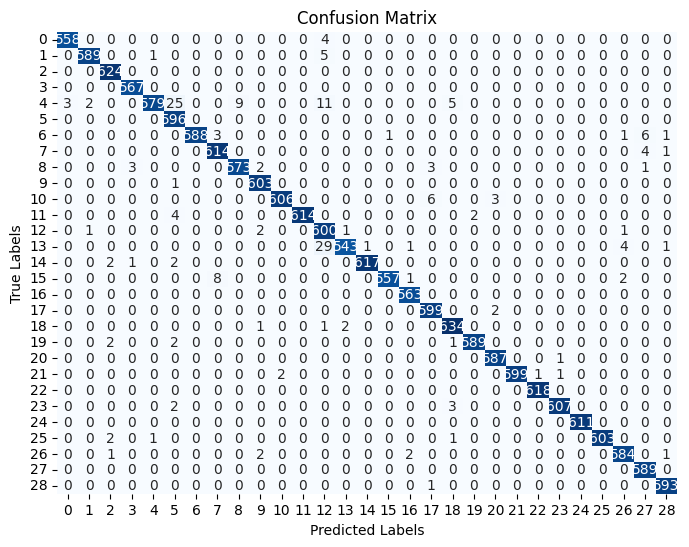

In [ ]:
def evaluate_model(model, val_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return precision, recall, f1, conf_matrix

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

val_precision, val_recall, val_f1_score, val_confusion_mat = evaluate_model(models['ResNet50'], val_loader, device)
print(f"Model Precision: {val_precision}")
print(f"Model Recall: {val_recall}")
print(f"Model F1 Score: {val_f1_score}")
print("Model Confusion Matrix:")
plot_confusion_matrix(val_confusion_mat)


Precision: 0.9642857142857143
Recall: 0.9285714285714286
F1 Score: 0.9285714285714286
Confusion Matrix:


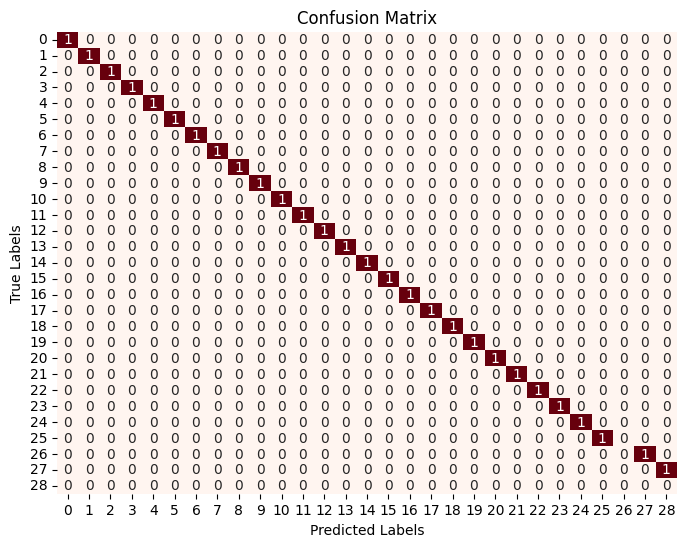

In [ ]:

def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted', zero_division=1)
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return precision, recall, f1, conf_matrix


def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

precision, recall, f1_score, confusion_mat = evaluate_model(models['ResNet50'], test_loader, device)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print("Confusion Matrix:")
plot_confusion_matrix(confusion_mat)


Our initial test set has no class segregation, so we our randomly taking 4 images from that test and asking our model to classify our images.

In [ ]:
test_path='/content/asl_alphabet_test/asl_alphabet_test'

In [ ]:

test_images = os.listdir(test_path)

def classify_images(model, test_images_path, transform, device, num_examples=1):
    model.eval()
    class_labels = [key for key, _ in test_loader.dataset.class_to_idx.items()]

    selected_images = test_images[:num_examples]

    for img_name in selected_images:
        img_path = os.path.join(test_images_path, img_name)
        img = Image.open(img_path).convert('RGB')
        img = transform(img).unsqueeze(0).to(device)

        output = model(img)
        _, predicted = torch.max(output, 1)
        predicted_label = class_labels[predicted.item()]

        print(f"Image: {img_name}, Predicted Label: {predicted_label}")


classify_images(models['ResNet50'], test_path, data_transforms, device, num_examples=4)


Image: W_test.jpg, Predicted Label: W
Image: I_test.jpg, Predicted Label: I
Image: X_test.jpg, Predicted Label: X
Image: M_test.jpg, Predicted Label: M


**Audio Implementation**

We have included a small text to speech implementation in our model so when it classifies an image it reads out the sign it has identified

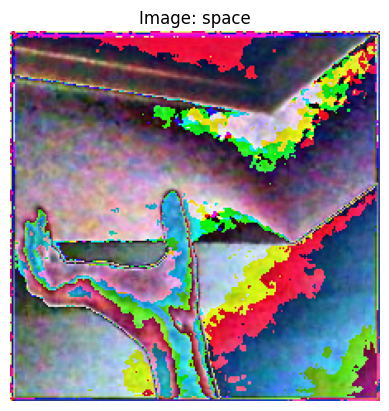

Predicted Label: space


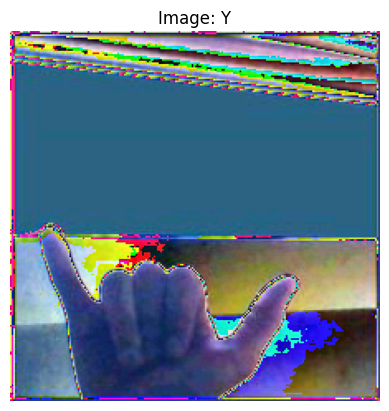

Predicted Label: Y


In [ ]:
def predict_image(model, test_loader, device, num_examples=2):
    model.eval()

    class_labels = [key for key, value in test_loader.dataset.class_to_idx.items()]

    for _ in range(num_examples):
        random_index = random.randint(0, len(test_loader.dataset) - 1)
        image, label = test_loader.dataset[random_index]

        image = image.unsqueeze(0).to(device)

        output = model(image)
        _, predicted = torch.max(output.data, 1)
        predicted_label = predicted.item()

        transformed_image = transforms.ToPILImage()(image.squeeze(0).cpu())
        plt.imshow(transformed_image)
        plt.title(f"Image: {class_labels[predicted_label]}")
        plt.axis('off')
        plt.show()

        predicted_class_label = class_labels[predicted_label]

        tts_text = f"The American Sign Language shown is {predicted_class_label}"
        tts_predicted = gTTS(text=tts_text, lang='en')
        tts_predicted.save(f"predicted_label_{_}.mp3")

        print(f"Predicted Label: {predicted_class_label}")
        ipd.display(ipd.Audio(f"predicted_label_{_}.mp3"))

predict_image(models['ResNet50'], test_loader, device, num_examples=2)
